# LoRE

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt



In [ ]:
# LoRe recalibration function
    # Compute kernel weights
def kernel_function(x1, x2, gamma):
      return np.exp(-np.linalg.norm(x1 - x2, ord=1) / (2 * gamma))

def lore_recalibrate(x, calibration_data, calibration_labels, gamma, num_bins=15):
    # Extract features (in this case, just 'HINCP' and 'BLACK')
    x_features = x.values
    calib_features = calibration_data.values

    # Compute confidences for calibration data
    confidences = rf_model.predict_proba(calibration_data)[:, 1]  # Assuming binary classification

    # Bin the confidences
    bins = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(confidences, bins) - 1

    # Find samples in the same bin as x
    x_confidence = rf_model.predict_proba(x.values.reshape(1, -1))[0, 1]
    x_bin = np.digitize(x_confidence, bins) - 1
    same_bin_indices = np.where(bin_indices == x_bin)[0]

    distances = np.sum(np.abs(x_features - calib_features[same_bin_indices]), axis=1)
    kernel_weights = np.exp(-distances / (2 * gamma))

    #kernel_weights = [kernel_function(x_features, calibration_data.iloc[i][['X1', 'X2']].values, gamma)
    #                for i in same_bin_indices]

    y_calib_array = np.array(calibration_labels).flatten()
    y_pred1 = rf_model.predict(calibration_data.iloc[same_bin_indices,:])
    comparison_result = y_calib_array[same_bin_indices] == y_pred1.flatten()
    recalibrated_confidence = np.sum(kernel_weights*comparison_result)/np.sum(kernel_weights)

    return recalibrated_confidence

In [ ]:
def evaluate_calibration(y_true, y_prob):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    brier = brier_score_loss(y_true, y_prob)
    return brier, prob_true, prob_pred

In [ ]:
def lore_recalibrate(x, calibration_data, calibration_labels, gamma, num_bins=15, epsilon=1e-8):
    x_features = x[['X1', 'X2']].values.reshape(1, -1)
    calib_features = calibration_data[['X1', 'X2']].values

    confidences = rf_model.predict_proba(calibration_data)[:, 1]

    bins = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(confidences, bins) - 1

    x_confidence = rf_model.predict_proba(x.values.reshape(1, -1))[0, 1]
    x_bin = np.digitize(x_confidence, bins) - 1
    same_bin_mask = bin_indices == x_bin

    if not np.any(same_bin_mask):
        return x_confidence

    distances = np.sum(np.abs(x_features - calib_features[same_bin_mask]), axis=1)
    kernel_weights = np.exp(-distances / (2 * gamma))

    if np.all(kernel_weights < epsilon):
        return x_confidence

    calib_predictions = rf_model.predict(calibration_data[same_bin_mask])
    weighted_accuracy = np.sum(kernel_weights * (calib_predictions == calibration_labels[same_bin_mask].values))

    recalibrated_confidence = weighted_accuracy / (np.sum(kernel_weights) + epsilon)

    return recalibrated_confidence

In [ ]:
# Generate simulated data
np.random.seed(1090)
n_samples = 5000

# Generate features
x1 = np.random.normal(0, 1, n_samples)  # Continuous variable 1
x2 = np.random.normal(0, 1, n_samples)  # Continuous variable 2
x3 = np.random.binomial(1, 0.5, n_samples)  # Discrete variable (0 or 1)

# Generate target variable
y_prob = 1 / (1 + np.exp(-(x1 + x2 + 2*x3 - 0.5)))
y = np.random.binomial(1, y_prob)

# Create DataFrame
df = pd.DataFrame({
    'X1': x1,
    'X2': x2,
    'X3': x3,
    'Y': y
})

# Split the data
features = ['X1', 'X2', 'X3']
X = df[features]
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1090)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1090)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=1090)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=1090)

In [ ]:
recalibrated_confidences = np.array([lore_recalibrate(row, X_val, y_val, 25)
                                     for _, row in X_test.iterrows()])

In [ ]:
recalibrated_confidences

In [ ]:
original_confidences = rf_model.predict_proba(X_test)[:, 1]

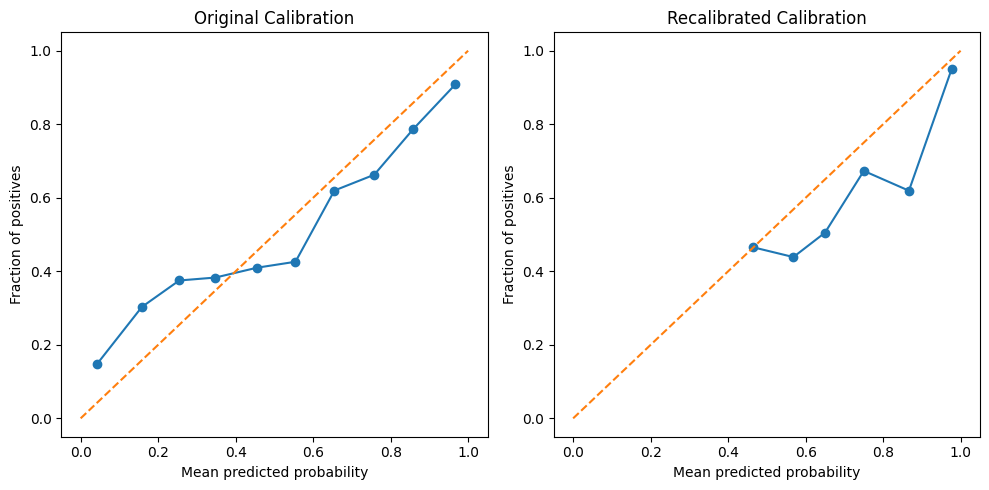

In [ ]:
def plot_calibration_curve(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_calibration_curve(y_test, original_confidences)
plt.title('Original Calibration')

plt.subplot(1, 2, 2)
plot_calibration_curve(y_test, recalibrated_confidences)
plt.title('Recalibrated Calibration')

plt.tight_layout()
plt.show()

In [ ]:
# prompt: get brier score using recalibrated_confidences and original

# Brier score for original and recalibrated confidences
brier_original = brier_score_loss(y_test, original_confidences)
brier_recalibrated = brier_score_loss(y_test, recalibrated_confidences)

print("Brier score (original):", brier_original)
print("Brier score (recalibrated):", brier_recalibrated)


Brier score (original): 0.18969253333333333
Brier score (recalibrated): 0.25801685770860944


# Trainable Kernel Calibration Metrics

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Import the original classes from your losses.py file
from src.metrics.losses import ClassificationKernelLoss, ClassificationMixedLoss,ECEKDEMixedLoss, MMCEMixedLoss

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )
        self.output_size = 2  # Required for ClassificationKernelLoss

    def forward(self, x):
        return self.fc(x)

class LogisticRegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 2)
        self.output_size = 2  # Required for ClassificationKernelLoss

    def forward(self, x):
        return self.linear(x)

# Training function
def train_model(model, loss_fn, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        for batch in train_loader:
            inputs, targets = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(inputs, targets, outputs)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/afarahi/Scientific-Machine-Learning/main/AHS_2019_Cleaned.CSV').drop('Unnamed: 0', axis=1)
df.head()

,BLACK,HHSEX,METRO,HHGRAD,HHMAR,HHCITSHP,HHAGE,NUMPEOPLE,HINCP,DIVISION,OWNER
0,0.0,1,1.0,44,1,1,52,3,5.409933,5,1.0
1,0.0,2,1.0,44,4,1,80,2,5.303196,1,1.0
2,0.0,1,1.0,47,1,1,72,2,4.825426,7,1.0
3,1.0,2,1.0,40,6,1,60,1,4.544068,4,0.0
4,0.0,2,1.0,39,3,1,80,2,4.309630,4,0.0


In [ ]:
# convert category dtype to numeric
df['OWNER']=df['OWNER'].astype('int64')

In [ ]:
df['OWNER']=df['OWNER'].astype('category')
features = ['BLACK', 'HHSEX', 'METRO', 'HHGRAD', 'HHMAR', 'HHCITSHP', 'HHAGE', 'NUMPEOPLE', 'HINCP', 'DIVISION']
dependent_var = ['OWNER']

X = df[features]
y = df[dependent_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1090)
condition_test=X_test.index

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)

X_test_tensor = torch.FloatTensor(X_test_scaled)


y_train_tensor = torch.tensor(y_train['OWNER'].values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test['OWNER'].values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# Train with standard cross-entropy loss
model_ce = LogisticRegressionNN(input_dim=10)
optimizer_ce = optim.Adam(model_ce.parameters(), lr=0.01)
train_model(model_ce, lambda x, y, z: nn.CrossEntropyLoss()(z, y), optimizer_ce)


Epoch 10, Loss: 0.4381
Epoch 20, Loss: 0.4829
Epoch 30, Loss: 0.2874
Epoch 40, Loss: 0.7129
Epoch 50, Loss: 0.2871
Epoch 60, Loss: 0.5716
Epoch 70, Loss: 0.6279
Epoch 80, Loss: 0.3661
Epoch 90, Loss: 0.6106
Epoch 100, Loss: 0.4607


In [ ]:
# Train with mixed loss (including kernel-based calibration)
model_mixed = LogisticRegressionNN(input_dim=10)
mixed_loss = ClassificationMixedLoss(
    loss_scalers={"nll": 1.0, "mmd": 0.7},
    operands={'x': "rbf", 'y': "rbf"},
    scalers={'x': 1.0, 'y': 1.0},
    bandwidths={'x': 25, 'y': 1}
)
optimizer_mixed = optim.Adam(model_mixed.parameters(), lr=0.01)
train_model(model_mixed, mixed_loss, optimizer_mixed)

Epoch 10, Loss: 0.2727
Epoch 20, Loss: 0.6127
Epoch 30, Loss: 0.4606
Epoch 40, Loss: 0.4149
Epoch 50, Loss: 0.6971
Epoch 60, Loss: 0.5425
Epoch 70, Loss: 0.3975
Epoch 80, Loss: 0.5681
Epoch 90, Loss: 0.4822
Epoch 100, Loss: 0.2954


In [ ]:
model_ecekde = LogisticRegressionNN(input_dim=10)
ecekde_loss = ECEKDEMixedLoss(
    loss_scalers={"nll": 1.0, "ece_kde": 0.7},
    bandwidth=25,
    p=1,
    mc_type='canonical'
)
optimizer_ecekde = optim.Adam(model_ecekde.parameters(), lr=0.01)
train_model(model_ecekde, ecekde_loss, optimizer_ecekde)

# Train with MMCEMixedLoss
model_mmce = LogisticRegressionNN(input_dim=10)
mmce_loss = MMCEMixedLoss(
    loss_scalers={"nll": 1.0, "mmce": 0.7}
)
optimizer_mmce = optim.Adam(model_mmce.parameters(), lr=0.01)
train_model(model_mmce, mmce_loss, optimizer_mmce)

Epoch 10, Loss: 0.7334
Epoch 20, Loss: 0.7346
Epoch 30, Loss: 0.7382
Epoch 40, Loss: 0.6804
Epoch 50, Loss: 0.7735
Epoch 60, Loss: 0.6534
Epoch 70, Loss: 0.6488
Epoch 80, Loss: 0.7341
Epoch 90, Loss: 0.7021
Epoch 100, Loss: 0.7228
Epoch 10, Loss: 0.6849
Epoch 20, Loss: 0.5739
Epoch 30, Loss: 0.6999
Epoch 40, Loss: 0.5945
Epoch 50, Loss: 0.7454
Epoch 60, Loss: 0.2742
Epoch 70, Loss: 0.7872
Epoch 80, Loss: 0.7010
Epoch 90, Loss: 0.7828
Epoch 100, Loss: 0.7614


In [ ]:
# Train with standard cross-entropy loss
model_ce = SimpleModel(input_dim=10)
optimizer_ce = optim.Adam(model_ce.parameters(), lr=0.01)
train_model(model_ce, lambda x, y, z: nn.CrossEntropyLoss()(z, y), optimizer_ce)

# Train with mixed loss
model_mixed = SimpleModel(input_dim=10)
mixed_loss = ClassificationMixedLoss(
    loss_scalers={"nll": 1.0, "mmd": 0.7},
    operands={'x': "rbf", 'y': "rbf"},
    scalers={'x': 1.0, 'y': 1.0},
    bandwidths={'x': 25, 'y': 1}
)
optimizer_mixed = optim.Adam(model_mixed.parameters(), lr=0.01)
train_model(model_mixed, mixed_loss, optimizer_mixed)


Epoch 10, Loss: 0.3999
Epoch 20, Loss: 0.4848
Epoch 30, Loss: 0.4517
Epoch 40, Loss: 0.4195
Epoch 50, Loss: 0.3291
Epoch 60, Loss: 0.5501
Epoch 70, Loss: 0.6058
Epoch 80, Loss: 0.4137
Epoch 90, Loss: 0.4968
Epoch 100, Loss: 0.4332
Epoch 10, Loss: 0.3288
Epoch 20, Loss: 0.6846
Epoch 30, Loss: 0.4797
Epoch 40, Loss: 0.5473
Epoch 50, Loss: 0.7111
Epoch 60, Loss: 0.6544
Epoch 70, Loss: 0.6134
Epoch 80, Loss: 0.4593
Epoch 90, Loss: 0.4232
Epoch 100, Loss: 0.4322


In [ ]:
# Evaluation function
def evaluate_calibration(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        probs = torch.softmax(logits, dim=1)[:, 1]

    probs = probs.numpy()
    y = y.numpy()

    # Calculate ECE
    n_bins = 10
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accuracies = []
    confidences = []
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(probs > bin_lower, probs <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(y[in_bin] == (probs[in_bin] > 0.5))
            avg_confidence_in_bin = np.mean(probs[in_bin])
            accuracies.append(accuracy_in_bin)
            confidences.append(avg_confidence_in_bin)

    ece = np.abs(np.array(accuracies) - np.array(confidences)).mean()
    return ece

# Evaluate both models
ece_ce= evaluate_calibration(model_ce, X_test_tensor, y_test_tensor)
ece_mixed = evaluate_calibration(model_mixed, X_test_tensor, y_test_tensor)
ece_ecekde = evaluate_calibration(model_ecekde, X_test_tensor, y_test_tensor)
ece_mmce = evaluate_calibration(model_mmce, X_test_tensor, y_test_tensor)

print(f"ECE (Cross-Entropy): {ece_ce:.4f}")
print(f"ECE (MMD Mixed Loss): {ece_mixed:.4f}")
print(f"ECE (ECEKDE Mixed Loss): {ece_ecekde:.4f}")
print(f"ECE (MMCE Mixed Loss): {ece_mmce:.4f}")


ECE (Cross-Entropy): 0.2456
ECE (MMD Mixed Loss): 0.2521
ECE (ECEKDE Mixed Loss): 0.2420
ECE (MMCE Mixed Loss): 0.2541


In [ ]:
model_ce.eval()
with torch.no_grad():
  logits = model_ce(X_test_tensor)
  probs = torch.softmax(logits, dim=1)[:, 1]
probs_ce = probs.numpy()

model_mixed.eval()
with torch.no_grad():
  logits = model_mixed(X_test_tensor)
  probs = torch.softmax(logits, dim=1)[:, 1]
probs_mixed = probs.numpy()

model_ecekde.eval()
with torch.no_grad():
  logits = model_mixed(X_test_tensor)
  probs = torch.softmax(logits, dim=1)[:, 1]
probs_ecekde = probs.numpy()

model_mmce.eval()
with torch.no_grad():
  logits = model_mixed(X_test_tensor)
  probs = torch.softmax(logits, dim=1)[:, 1]
probs_mmce = probs.numpy()

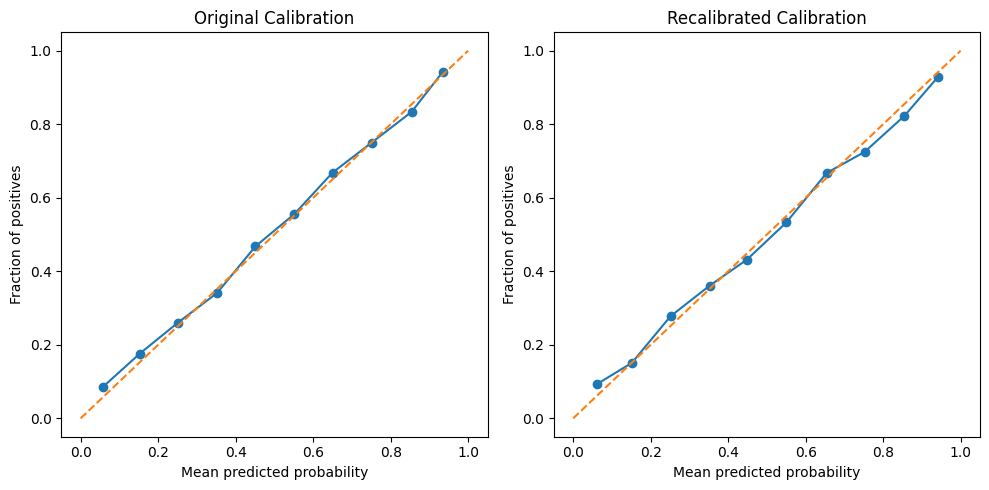

In [ ]:
def plot_calibration_curve(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_calibration_curve(y_test_tensor, probs_ce)
plt.title('Original Calibration')

plt.subplot(1, 2, 2)
plot_calibration_curve(y_test_tensor, probs_mixed)
plt.title('Recalibrated Calibration')

plt.tight_layout()
plt.show()

In [ ]:
# prompt: compare brier score of model_ce and model_mixed

from sklearn.metrics import brier_score_loss

# Get predicted probabilities for both models
model_ce.eval()
with torch.no_grad():
  logits_ce = model_ce(X_test_tensor)
  probs_ce = torch.softmax(logits_ce, dim=1)[:, 1].numpy()

model_mixed.eval()
with torch.no_grad():
  logits_mixed = model_mixed(X_test_tensor)
  probs_mixed = torch.softmax(logits_mixed, dim=1)[:, 1].numpy()

# Calculate Brier scores
brier_ce = brier_score_loss(y_test, probs_ce)
brier_mixed = brier_score_loss(y_test, probs_mixed)
brier_ecekde=brier_score_loss(y_test, probs_ecekde)
brier_mmce = brier_score_loss(y_test, probs_mmce)

print(f"Brier score (Cross-Entropy): {brier_ce:.4f}")
print(f"Brier score (MMD Mixed Loss): {brier_mixed:.4f}")
print(f"Brier score (ECEKDE Mixed Loss): {brier_ecekde:.4f}")
print(f"Brier score (MMCE Mixed Loss): {brier_mmce:.4f}")


Brier score (Cross-Entropy): 0.1701
Brier score (MMD Mixed Loss): 0.1692
Brier score (ECEKDE Mixed Loss): 0.1634
Brier score (MMCE Mixed Loss): 0.1634


In [ ]:
from KiTE.metrics import ELCE2

In [ ]:
probs_mixed

array([0.17861862, 0.82975787, 0.66047114, ..., 0.13750766, 0.6560978 ,
       0.81280345], dtype=float32)

In [ ]:
ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,probs_mixed, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)

(0.00035714380237850243,
 array([-2.32574785e-05, -9.87173655e-05, -7.75080666e-05, -2.32592663e-05,
         6.95784503e-05, -4.76918902e-05,  6.56900839e-05, -7.35729016e-05,
         1.71009923e-05, -3.37117589e-05, -3.00570308e-05,  7.74750197e-06,
        -1.02272653e-04, -4.42929588e-05, -4.37566235e-06, -5.43538502e-05,
        -1.00763245e-04,  1.02148196e-04,  6.87254574e-05,  1.76714631e-05,
        -7.40794064e-05, -9.45903061e-05,  7.99827271e-06,  1.27340036e-04,
         6.98817190e-06, -6.52842065e-05,  6.72477413e-06, -3.96693207e-05,
         9.21896622e-05, -4.17948709e-05,  2.55312446e-05,  1.38583442e-07,
         1.94595115e-05, -1.26794226e-05, -5.52088585e-05, -4.35171673e-05,
        -2.24657921e-05, -6.27545573e-05,  3.32444952e-05,  7.76381930e-05,
         1.37444239e-04, -8.00246674e-05, -1.52850495e-05, -8.85782451e-05,
         5.24382934e-06, -3.03468060e-05, -9.68492229e-05, -2.23506596e-05,
         1.69398649e-05, -5.12081482e-05,  3.98414828e-05, -8.7

In [ ]:
ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,probs_ecekde, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)

(0.00035714380237850243,
 array([-1.15936945e-05,  7.16082387e-05,  8.96030665e-05, -4.43142958e-05,
         1.43826420e-04,  1.79336760e-05, -4.37845517e-05, -2.77659314e-05,
        -7.61852853e-06,  9.38992058e-05, -9.11624763e-06, -6.21175564e-05,
         7.48435023e-05, -2.38908493e-05, -7.27024794e-05,  4.31131957e-05,
         2.60913318e-04, -6.46046263e-05, -2.80618737e-06,  2.06070852e-05,
         8.00695054e-05, -9.39031698e-05, -7.25079945e-05,  3.13924396e-05,
        -5.38350936e-05, -3.07221634e-05, -6.41052303e-05, -8.07110554e-05,
        -5.94422856e-05,  1.00084190e-04,  6.45057590e-05, -8.65565745e-05,
         5.62587465e-06, -5.07374351e-05, -1.56164085e-05,  9.41270235e-05,
        -1.61545026e-05, -1.15192331e-04,  6.02205247e-05, -9.32764103e-05,
         4.10033148e-05,  5.49212220e-05,  4.41956526e-05, -3.24823834e-05,
         4.48207299e-05,  8.46036464e-05, -7.26990580e-06, -8.12902676e-05,
        -3.55791341e-05,  5.58620254e-05, -8.58958098e-05,  2.2

In [ ]:
ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,probs_mmce, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)

(0.00035714380237850243,
 array([-8.64831799e-05,  6.72051597e-05,  6.27154072e-05,  4.98526277e-05,
        -9.12297694e-05, -4.21730388e-05, -6.14744175e-05, -1.38181243e-05,
         3.58822608e-05, -6.39826409e-05,  1.03213394e-05,  1.78069168e-04,
        -1.14643083e-04,  1.28662311e-04,  1.29070893e-04,  2.80995949e-05,
         4.31145209e-05,  2.40494501e-05, -3.87683291e-05, -3.15568230e-05,
         3.36032248e-05, -1.35585658e-05, -7.09756380e-05, -7.65100257e-05,
        -1.76781731e-05,  1.58035157e-05, -1.20008812e-04,  1.87274954e-04,
         9.10486312e-05, -1.07498188e-04,  1.70720055e-05, -5.48364218e-05,
         2.32238661e-05,  5.53801842e-05,  6.00607416e-06,  2.31987580e-05,
        -2.58571351e-05, -3.87293868e-05, -2.65373785e-05, -5.87774507e-05,
        -5.13783872e-05,  1.20566501e-04,  4.80432914e-05,  1.81293703e-04,
         9.75400864e-05,  6.05992084e-05, -4.75127415e-06,  2.09605044e-05,
        -1.95002479e-05,  1.60262883e-04,  1.26026789e-04, -1.3

In [ ]:
ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,probs_ce, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)

(0.0009982300381829578,
 array([ 5.90283282e-05,  1.51943206e-04, -1.54327721e-05, -1.17205218e-04,
         1.60568598e-04, -9.28372476e-05, -1.24096116e-04,  7.33559844e-05,
        -3.14390582e-05,  4.19842337e-05, -1.58475318e-04,  1.87510763e-05,
         2.00356477e-04, -6.26603209e-05,  7.97990787e-06,  1.39588702e-04,
        -8.86735322e-05, -1.55199516e-04, -2.93026356e-05, -1.88997410e-05,
         6.64713580e-05,  6.03180308e-05,  1.48143232e-05,  1.43114338e-04,
        -1.08098831e-05,  1.65566610e-04, -7.03555407e-05,  1.02723192e-05,
        -1.11632608e-04, -8.75754205e-06, -1.04220401e-04,  1.32894351e-04,
         4.75205282e-06, -6.10954339e-05, -2.09611835e-05, -1.26941789e-04,
        -2.65683051e-05, -1.41578098e-04,  7.74175099e-06,  8.84088740e-06,
        -1.89711338e-05,  3.66126325e-04, -5.21305854e-06,  8.14014249e-06,
        -1.18367104e-04,  1.18517669e-04, -7.97466964e-05, -2.39334300e-05,
        -4.28069918e-05, -1.14792783e-04,  3.86364963e-05, -1.25